In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data/listings.csv")

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Clean price data - remove $ and convert to numeric
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    # Remove $ and commas, convert to float
    return float(re.sub(r'[\$,]', '', str(price_str)))

data['price_numeric'] = data['price'].apply(clean_price)

In [5]:
# Cell 4: Normalization Function and Implementation
def normalize(X):
    """
    Normalize features to have zero mean and unit variance.
    
    Parameters:
    X (pandas.DataFrame or numpy.array): Input features
    
    Returns:
    X_normalized (pandas.DataFrame or numpy.array): Normalized features
    means (pandas.Series or numpy.array): Mean values used for normalization
    stds (pandas.Series or numpy.array): Standard deviations used for normalization
    """
    means = X.mean()
    stds = X.std()
    X_normalized = (X - means) / stds
    return X_normalized, means, stds

In [6]:
# Cell 7: Feature Engineering and Preprocessing
# Create binary variables for categorical features
data['host_is_superhost_binary'] = (data['host_is_superhost'] == 't').astype(int)
data['instant_bookable_binary'] = (data['instant_bookable'] == 't').astype(int)

# Handle room_type - create dummy variables
room_type_dummies = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, room_type_dummies], axis=1)

# Handle property_type - keep only most common types
property_type_counts = data['property_type'].value_counts()
top_property_types = property_type_counts.head(5).index
data['property_type_simplified'] = data['property_type'].apply(
    lambda x: x if x in top_property_types else 'Other'
)
property_type_dummies = pd.get_dummies(data['property_type_simplified'], prefix='property_type')
data = pd.concat([data, property_type_dummies], axis=1)

In [7]:
# Cell 8: Feature Selection for Model
# Select features for the model
feature_columns = [
    # Numerical features
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'latitude', 'longitude',
    'calculated_host_listings_count', 'reviews_per_month',
    
    # Binary features
    'host_is_superhost_binary', 'instant_bookable_binary',
    
    # Room type dummies (exclude one to avoid multicollinearity)
    'room_type_Entire home/apt', 'room_type_Private room',
    
    # Property type dummies (exclude one to avoid multicollinearity)
]

# Add property type dummies to feature list (excluding one category)
property_dummies = [col for col in data.columns if col.startswith('property_type_')]
if property_dummies:
    feature_columns.extend(property_dummies[:-1])  # Exclude last one

# Add review scores if available and not too many missing values
review_score_cols = ['review_scores_rating', 'review_scores_cleanliness', 
                    'review_scores_location', 'review_scores_value']
for col in review_score_cols:
    if col in data.columns and data[col].isnull().sum() < len(data) * 0.5:
        feature_columns.append(col)

print("Selected features:", feature_columns)

Selected features: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'availability_365', 'minimum_nights', 'latitude', 'longitude', 'calculated_host_listings_count', 'reviews_per_month', 'host_is_superhost_binary', 'instant_bookable_binary', 'room_type_Entire home/apt', 'room_type_Private room', 'property_type_simplified', 'property_type_Entire condo', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Other', 'property_type_Private room in rental unit', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value']


In [8]:
# Cell 9: Data Cleaning and Preparation (Revised)

# Remove rows with missing target values
clean_data = data.dropna(subset=['price_numeric']).copy()

# Remove extreme outliers in price (beyond 3 standard deviations)
price_mean = clean_data['price_numeric'].mean()
price_std = clean_data['price_numeric'].std()
clean_data = clean_data[
    (clean_data['price_numeric'] >= price_mean - 3*price_std) &
    (clean_data['price_numeric'] <= price_mean + 3*price_std)
]

# Cell 7: Feature Engineering and Preprocessing (Merged and Corrected)
# Create binary variables for categorical features
clean_data['host_is_superhost_binary'] = (clean_data['host_is_superhost'] == 't').astype(int)
clean_data['instant_bookable_binary'] = (clean_data['instant_bookable'] == 't').astype(int)

# Handle room_type - create dummy variables
room_type_dummies = pd.get_dummies(clean_data['room_type'], prefix='room_type')
clean_data = pd.concat([clean_data, room_type_dummies], axis=1)

# Handle property_type - keep only most common types
property_type_counts = clean_data['property_type'].value_counts()
top_property_types = property_type_counts.head(5).index
clean_data['property_type_simplified'] = clean_data['property_type'].apply(
    lambda x: x if x in top_property_types else 'Other'
)
property_type_dummies = pd.get_dummies(clean_data['property_type_simplified'], prefix='property_type')
data_with_dummies = pd.concat([clean_data, property_type_dummies], axis=1)

# Handle neighborhood_cleansed - create dummy variables
neighbourhood_dummies = pd.get_dummies(data_with_dummies['neighbourhood_cleansed'], prefix='neighbourhood')
data_with_dummies = pd.concat([data_with_dummies, neighbourhood_dummies], axis=1)


# Cell 8: Feature Selection for Model (Merged and Corrected)
# Select features for the model
feature_columns = [
    # Numerical features
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'latitude', 'longitude',
    'calculated_host_listings_count', 'reviews_per_month',
    
    # Binary features
    'host_is_superhost_binary', 'instant_bookable_binary',
    
    # Room type dummies (exclude one to avoid multicollinearity)
    'room_type_Entire home/apt', 'room_type_Private room',
    
    # Property type dummies (excluding one for multicollinearity)
    *list(property_type_dummies.columns.drop('property_type_Other')), # Example: drop 'Other'
    
    # Neighborhood dummies (excluding one for multicollinearity)
    *list(neighbourhood_dummies.columns.drop(neighbourhood_dummies.columns[0])) # Drop the first one
]

# Add review scores if available and not too many missing values
review_score_cols = ['review_scores_rating', 'review_scores_cleanliness', 
                    'review_scores_location', 'review_scores_value']
for col in review_score_cols:
    if col in data_with_dummies.columns and data_with_dummies[col].isnull().sum() < len(data_with_dummies) * 0.5:
        feature_columns.append(col)

# Ensure no duplicate columns are in the list
feature_columns = list(dict.fromkeys(feature_columns))

print("Selected features:", feature_columns)
print(f"Number of features: {len(feature_columns)}")

# Prepare feature matrix
X = data_with_dummies[feature_columns].copy()

# Handle missing values in features
# For numerical columns, fill with median
numerical_cols = X.select_dtypes(include=np.number).columns
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

# For any remaining missing values, fill with 0
X = X.fillna(0)

# Target variable
y = data_with_dummies['price_numeric']

print(f"Final dataset shape: {X.shape}")
print(f"Target variable range: ${y.min():.2f} - ${y.max():.2f}")

Selected features: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'availability_365', 'minimum_nights', 'latitude', 'longitude', 'calculated_host_listings_count', 'reviews_per_month', 'host_is_superhost_binary', 'instant_bookable_binary', 'room_type_Entire home/apt', 'room_type_Private room', 'property_type_Entire condo', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Private room in rental unit', 'property_type_Room in hotel', 'neighbourhood_Brigittenau', 'neighbourhood_Donaustadt', 'neighbourhood_D\x9abling', 'neighbourhood_Favoriten', 'neighbourhood_Floridsdorf', 'neighbourhood_Hernals', 'neighbourhood_Hietzing', 'neighbourhood_Innere Stadt', 'neighbourhood_Josefstadt', 'neighbourhood_Landstra§e', 'neighbourhood_Leopoldstadt', 'neighbourhood_Liesing', 'neighbourhood_Margareten', 'neighbourhood_Mariahilf', 'neighbourhood_Meidling', 'neighbourhood_Neubau', 'neighbourhood_Ottakring', 'neighbourhood_Penzing', 'neighb

In [9]:
# Cell 10: Train-Test Split and Normalization
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features using the function you defined
def normalize(df):
    """
    Normalize features to have zero mean and unit variance.

    Parameters:
    df (pandas.DataFrame): Input features

    Returns:
    df_normalized (pandas.DataFrame): Normalized features
    means (pandas.Series): Mean values used for normalization
    stds (pandas.Series): Standard deviations used for normalization
    """
    means = df.mean()
    stds = df.std()
    # Handle the case where a feature has zero standard deviation
    stds[stds == 0] = 1
    df_normalized = (df - means) / stds
    return df_normalized, means, stds

X_train_normalized, means, stds = normalize(X_train)
X_test_normalized = (X_test - means) / stds

print(f"Training set shape: {X_train_normalized.shape}")
print(f"Test set shape: {X_test_normalized.shape}")

Training set shape: (7832, 53)
Test set shape: (1958, 53)


In [10]:
# Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_normalized, y_train)

# Make predictions
y_train_pred = rf_classifier.predict(X_train_normalized)
y_test_pred = rf_classifier.predict(X_test_normalized)


In [11]:
# Cell 12: Model Evaluation
# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: ${np.sqrt(train_mse):.2f}")
print(f"Test RMSE: ${np.sqrt(test_mse):.2f}")

Model Performance:
Training MSE: 0.68
Test MSE: 6164.68
Training R²: 0.9999
Test R²: 0.3046
Training RMSE: $0.82
Test RMSE: $78.52


AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

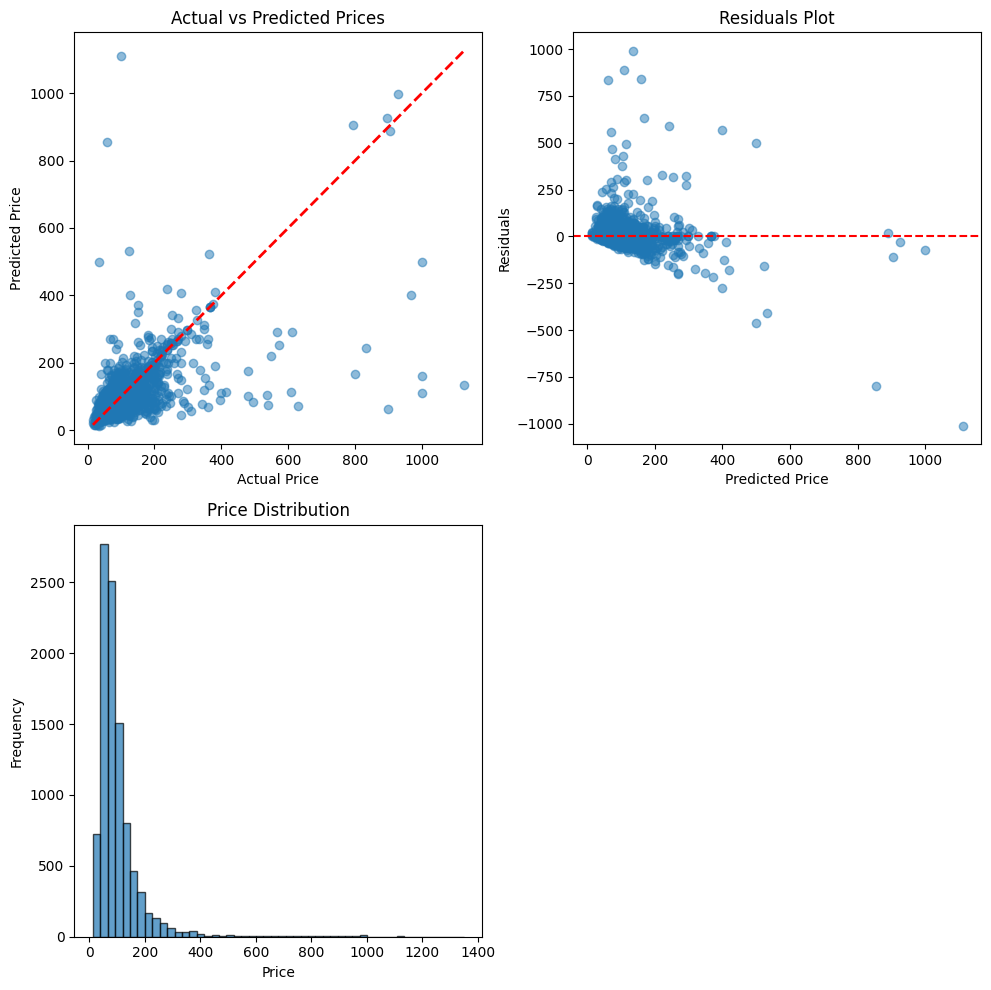

In [14]:
from scipy import stats

plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted scatter plot
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# 2. Residuals plot
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# 3. Feature importance bar plot
'''plt.subplot(2, 3, 3)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['abs_coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()'''

# 4. Price distribution
plt.subplot(2, 3, 4)
plt.hist(y, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')

plt.tight_layout()
plt.show()